In [4]:
import cv2
import os
from tqdm import tqdm
import json
import matplotlib.pyplot as plt
import math 
import numpy as np
import random
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn import metrics

In [5]:
sup_path = './benchmark_velocity_supp'
folder_sup = os.listdir(sup_path)
with open(os.path.join(sup_path,'annotation.json'),'r') as f:
    gt = json.load(f)
f.close()
#print(len(sup_gt))
imgs = []
cars = []
no_car = []
for i in tqdm(range(len(gt))):
    subset = gt[i]
    img = cv2.imread(os.path.join(sup_path,subset['file_name']))
    imgs.append(img)
    aim = subset['bbox']
    coordinates = []
    for j in aim:
        left = int(j['left'])
        top = int(j['top'])
        bottom = int(j['bottom'])
        right = int(j['right'])
        coordinates.append([(top - 10,bottom + 10),(left - 10,right + 10)])
        cars.append(img[top:bottom,left:right])
    count = 0
    while(count<15):
        h = random.randint(1,655) # prevent out of range
        v = random.randint(1,1200)
        for c in coordinates:
            if h in range(c[1][0],c[1][1]) and v in range(c[1][0],c[1][1]):
                break
        else:
            count += 1
            no_car.append(img[h:h+64,v:v+64])

100%|██████████| 5067/5067 [01:02<00:00, 80.85it/s]


In [6]:
cars = [i for i in cars if i.size]

In [7]:
cars_resized = []
for i in tqdm(range(len(cars))):
    gray_img = cv2.cvtColor(cars[i],cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(gray_img,(64, 64),interpolation = cv2.INTER_CUBIC)
    cars_resized.append(img_resized)
no_cars = []

100%|██████████| 29066/29066 [00:06<00:00, 4458.28it/s]


In [9]:
car_features = []
for i in tqdm(cars_resized):
    car_features.append(hog(i, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1), visualize=False,feature_vector=True))

100%|██████████| 29066/29066 [00:52<00:00, 550.88it/s]


In [10]:
nocar_features = []#feature_vector=True
for i in tqdm(no_car):
    i = cv2.cvtColor(i,cv2.COLOR_BGR2GRAY)
    temp = hog(i, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1), visualize=False, feature_vector=True)
    nocar_features.append(temp)

100%|██████████| 76005/76005 [03:41<00:00, 343.11it/s]


In [11]:
x = np.vstack((car_features, nocar_features))

In [12]:
y = np.hstack((np.ones(len(car_features)), np.zeros(len(nocar_features))))


In [13]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=0)

In [14]:
svc = LinearSVC()
svc.fit(x_train, y_train)

/Users/caihaowen/anaconda3/envs/E9517/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC()

In [15]:
print('My classfier predicts: ', svc.predict(x_test[0:1]))
#print('For these','labels: ', y_test[0:100])

My classfier predicts:  [0.]


In [16]:
predict = svc.predict(x_test)
accuracy = metrics.accuracy_score(y_test,predict)
recall = metrics.recall_score(y_test,predict,average='macro')
print(f"Accuracy:{accuracy:0.3f}\t Recall:{recall:0.3f}")
print("SVM")
print(metrics.confusion_matrix(y_test,predict))

Accuracy:0.952	 Recall:0.933
SVM
[[14821   366]
 [  646  5182]]


In [17]:
def slide_window(img, window_size=(64, 64), overlap=0.5):
    step = window_size[0] * (1 - overlap)
    number_of_window_x = int((img.shape[1] - 64 * overlap) / step)
    number_of_window_y = int((500 - 64 * overlap) / step)
    windows = []
    for y in range(number_of_window_y):
        for x in range(number_of_window_x):
            startx = int(x * step)
            endx = startx + window_size[0]
            starty = int(y * step) + 150
            endy = starty + window_size[1]
            # Append window position to list
            windows.append(((startx, starty), (endx, endy)))
    return windows                          

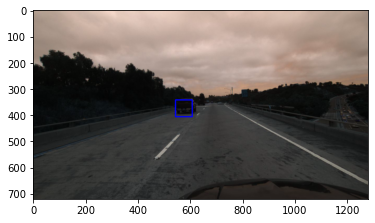

In [67]:
def search(img, windows, clf):
    result = []
    features = []
    for window in windows:
        #print(window)
        temp = img[window[0][1]:window[1][1], window[0][0]:window[1][0]]
        if temp.size:
            img_cropped = cv2.resize(temp, (64, 64))
            gray_img = cv2.cvtColor(img_cropped,cv2.COLOR_BGR2GRAY)
            #print(img_cropped.shape)
            features = hog(gray_img, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(1, 1), visualize=False, feature_vector=True)
            if clf.predict([features]):
                result.append(window)
    return result

def draw_windows(img,windows):
    draw_img = np.copy(img)
    for window in windows:
        cv2.rectangle(draw_img, window[0],window[1], (0, 0, 255), 3)
    return draw_img,windows
im = imgs[5]
draw_img,windows = draw_windows(im,search(im,slide_window(im),svc))
plt.imshow(draw_img)

In [19]:
from scipy.ndimage.measurements import label
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

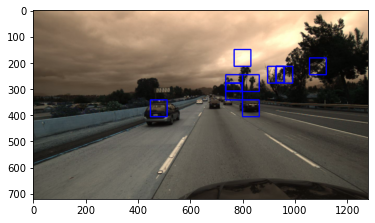

In [20]:
heat_map = np.zeros(im.shape[:2])
heat_map = add_heat(heat_map,windows)
heat_map_thresholded = apply_threshold(heat_map,1)
labels = label(heat_map_thresholded)
draw_img = draw_labeled_bboxes(draw_img,labels)
plt.imshow(draw_img)

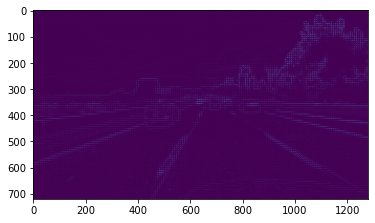

In [22]:
temp,image = hog(imgs[0], orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1), visualize=True, feature_vector=True)
plt.imshow(image)

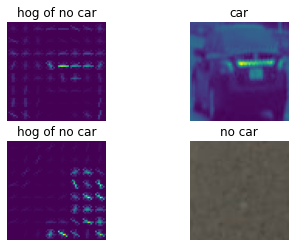

In [50]:
temp,image = hog(cars_resized[0], orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1), visualize=True, feature_vector=True)

temp,image1 = hog(no_car[5][:,:,1], orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1), visualize=True, feature_vector=True)
plt.subplot(2,2,1)
plt.axis('off')
plt.title('hog of no car')
plt.imshow(image)
plt.subplot(2,2,2)
plt.title('car')
plt.axis('off')
plt.imshow(cars_resized[0])

plt.subplot(2,2,3)
plt.title('hog of no car')
plt.axis('off')
plt.imshow(image1)
plt.subplot(2,2,4)
plt.title('no car')
plt.axis('off')
plt.imshow(no_car[0])